<a href="https://colab.research.google.com/github/Vinuji-Hewapathirana/Machine-Learning---Coursework/blob/main/ML_NN_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
# Load and preprocess data
data = pd.read_csv('bank-additional-full.csv', sep=';')
data = data.drop(columns=['duration', 'contact'])

In [ ]:
X = data.drop(columns=['y'])
y = data['y'].map({'yes': 1, 'no': 0})

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1828/1828 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7136 - auc: 0.7719 - loss: 0.5632 - val_accuracy: 0.7968 - val_auc: 0.8008 - val_loss: 0.5521
Epoch 2/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7449 - auc: 0.8188 - loss: 0.5199 - val_accuracy: 0.8291 - val_auc: 0.7949 - val_loss: 0.4914
Epoch 3/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7595 - auc: 0.8388 - loss: 0.4972 - val_accuracy: 0.7811 - val_auc: 0.7885 - val_loss: 0.5181
Epoch 4/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7764 - auc: 0.8553 - loss: 0.4756 - val_accuracy: 0.8122 - val_auc: 0.7842 - val_loss: 0.4697
Epoch 5/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7929 - auc: 0.8709 - loss: 0.4517 - val_accuracy: 0.8138 - val_auc: 0.7822 - val_loss: 0.4525
Epoch 6/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7993 - auc: 0.8776 - loss: 0.4401 - val_accuracy: 0.8128 - val_auc: 0.7782 - val_loss: 0.4463
Epoch 7/50
1828/1828 ━━━━━━━━━━━━━━━━━━

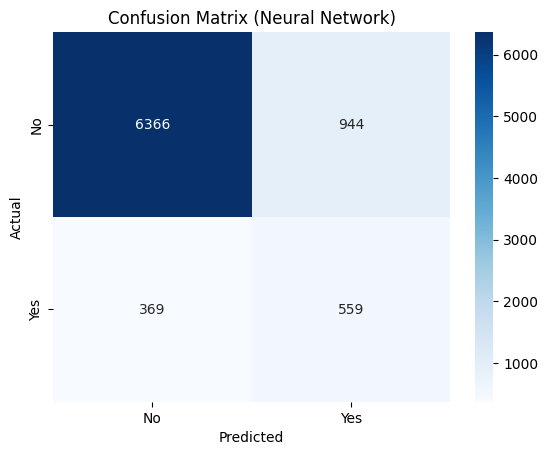

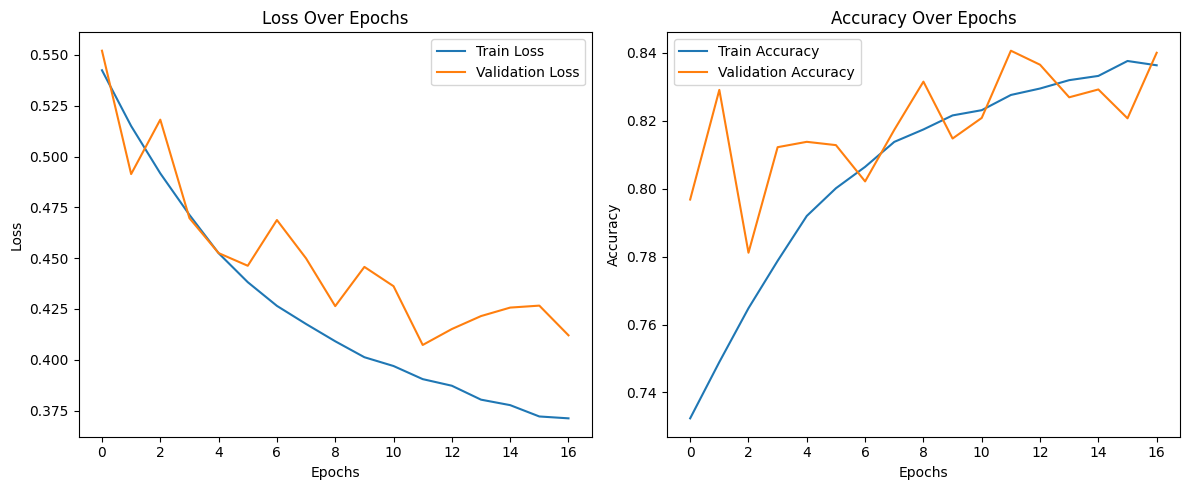

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Transform data using preprocessor
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

# Define the Neural Network model
input_dim = X_train_smote.shape[1]
model = Sequential([
    Dense(64, activation='relu', input_dim=input_dim),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Train the model with EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_test_transformed, y_test),
    epochs=50, batch_size=32, callbacks=[early_stopping]
)

# Evaluate the model
y_pred_prob = model.predict(X_test_transformed).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print("Classification Report (Neural Network)")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score (Neural Network):", roc_auc_score(y_test, y_pred_prob))

# Confusion Matrix
conf_matrix_nn = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title("Confusion Matrix (Neural Network)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()